In [1]:
# Core scientific and utility libraries
!pip install tqdm
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install opencv-python
!pip install pillow  # for PIL

# PyTorch and torchvision
!pip install torch torchvision torchaudio

# TensorBoard
!pip install tensorboard

# scikit-learn for evaluation metrics
!pip install scikit-learn

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [2]:
# Import Libraries
import os
import random
import shutil
import datetime
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [3]:
# Set fixed seed for reproducibility
random.seed(42)

In [4]:
# Configuration
image_size = 200
batch_size = 64
num_epochs = 50
learning_rate = 1e-4
patience = 5  # for early stopping

train_dir = 'dataset_blurred/Training'
test_dir = 'dataset/Testing'
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
# Custom Dataset
def is_image_file(fname):
    return any(fname.lower().endswith(ext) for ext in ['.png', '.jpg', '.jpeg', '.bmp'])

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, labels, transform=None):
        self.samples = []
        self.labels_map = {label: idx for idx, label in enumerate(labels)}
        self.transform = transform
        for label in labels:
            dir_path = os.path.join(root_dir, label)
            for fname in os.listdir(dir_path):
                if is_image_file(fname):
                    self.samples.append((os.path.join(dir_path, fname), self.labels_map[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
# Prepare Datasets and DataLoaders
full_train_ds = BrainTumorDataset(train_dir, labels, transform=train_transforms)
train_size = int(0.75 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
val_ds.dataset.transform = val_transforms

test_ds = BrainTumorDataset(test_dir, labels, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

In [8]:
# Model Definition
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_ftrs, len(labels))
)
model = model.to(device)

In [9]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5)

# TensorBoard Setup
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

# Utility: Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    return figure

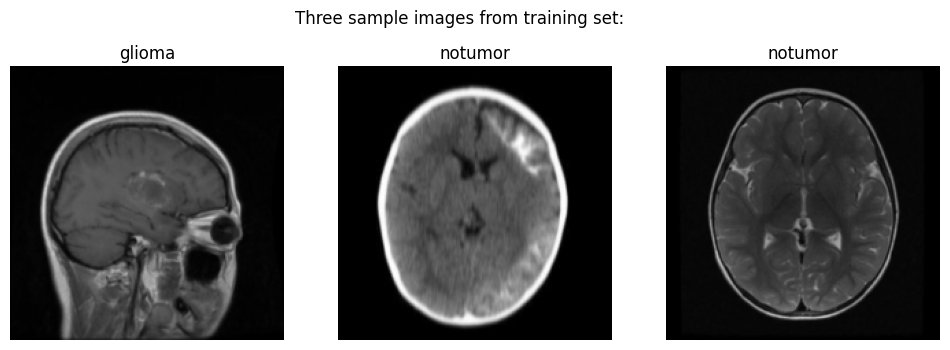

In [11]:
# Display sample images
num_samples = 3
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*4, 4))
for i in range(num_samples):
    img_tensor, lbl = train_ds[i]
    img = img_tensor * 0.5 + 0.5  # unnormalize
    img = img.permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].set_title(labels[lbl])
    axes[i].axis('off')
plt.suptitle('Three sample images from training set:')
plt.show()

In [12]:
# Training Loop with Early Stopping and Checkpointing
best_val_loss = float('inf')
no_improve_epochs = 0

# Keep track of metrics for plotting
train_losses_list = []
val_losses_list = []
train_accs_list = []
val_accs_list = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, running_corrects, total_samples = 0.0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == targets.data)
        total_samples += inputs.size(0)

    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = running_corrects.double() / total_samples

    # Validation phase
    model.eval()
    val_loss, val_corrects, val_samples = 0.0, 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == targets.data)
            val_samples += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    epoch_val_loss = val_loss / val_samples
    epoch_val_acc = val_corrects.double() / val_samples

    # Step scheduler
    scheduler.step(epoch_val_loss)

    # Record metrics for plotting
    train_losses_list.append(epoch_train_loss)
    val_losses_list.append(epoch_val_loss)
    train_accs_list.append(epoch_train_acc.item())
    val_accs_list.append(epoch_val_acc.item())

    # TensorBoard logging
    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_train_acc, epoch)
    writer.add_scalar('Accuracy/val', epoch_val_acc, epoch)
    cm = confusion_matrix(all_targets, all_preds)
    fig = plot_confusion_matrix(cm, labels)
    writer.add_figure('Confusion Matrix', fig, epoch)

    # Checkpoint & Early Stopping
    if epoch_val_loss < best_val_loss - 0.001:
        best_val_loss = epoch_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")

Epoch 1/50, Train Loss: 0.3175, Val Loss: 0.0976, Train Acc: 0.8856, Val Acc: 0.9692
Epoch 2/50, Train Loss: 0.0509, Val Loss: 0.0715, Train Acc: 0.9839, Val Acc: 0.9769
Epoch 3/50, Train Loss: 0.0209, Val Loss: 0.0555, Train Acc: 0.9937, Val Acc: 0.9769
Epoch 4/50, Train Loss: 0.0175, Val Loss: 0.0733, Train Acc: 0.9944, Val Acc: 0.9776
Epoch 5/50, Train Loss: 0.0162, Val Loss: 0.0730, Train Acc: 0.9949, Val Acc: 0.9755
Epoch 6/50, Train Loss: 0.0108, Val Loss: 0.0566, Train Acc: 0.9965, Val Acc: 0.9832
Epoch 7/50, Train Loss: 0.0084, Val Loss: 0.0825, Train Acc: 0.9981, Val Acc: 0.9776
Early stopping at epoch 8


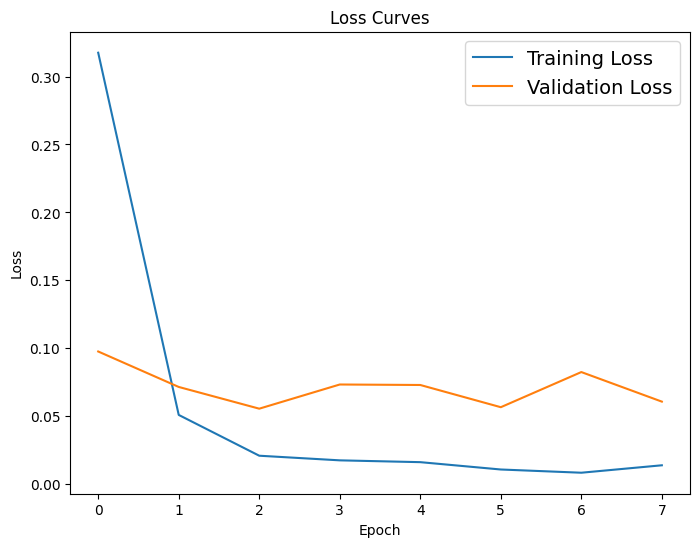

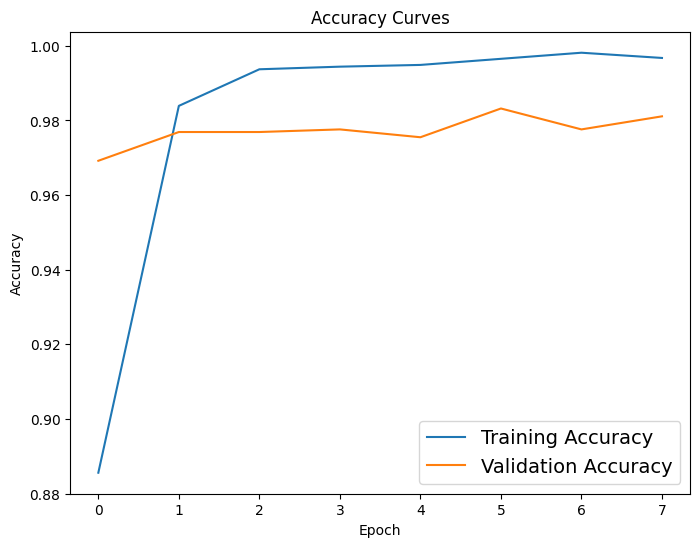

In [13]:
# Plot Learning Curves
plt.figure(figsize=[8,6])
plt.plot(train_losses_list, label='Training Loss')
plt.plot(val_losses_list, label='Validation Loss')
plt.legend(fontsize=14)
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=[8,6])
plt.plot(train_accs_list, label='Training Accuracy')
plt.plot(val_accs_list, label='Validation Accuracy')
plt.legend(fontsize=14)
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Test Loss: 0.0640, Test Accuracy: 0.9710


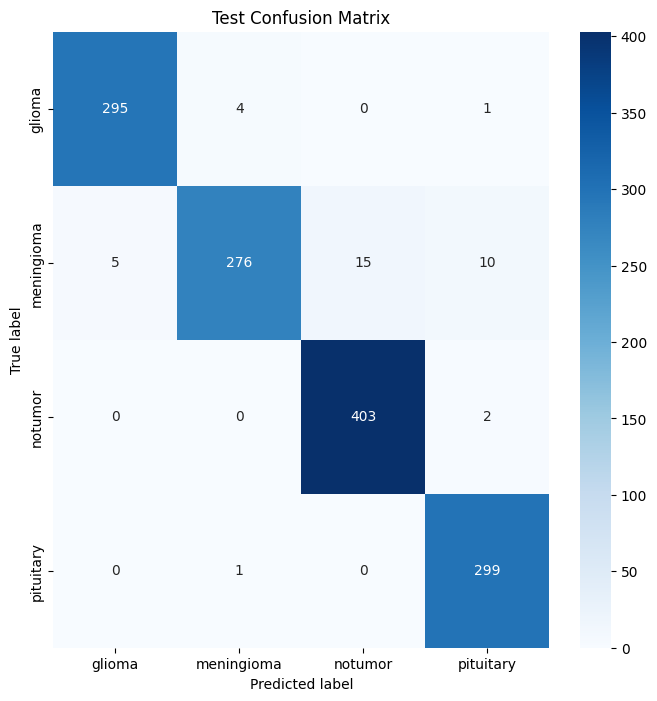

              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       300
  meningioma       0.98      0.90      0.94       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [14]:
# Evaluation on Test Set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss, test_corrects, test_samples = 0.0, 0, 0
all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == targets.data)
        test_samples += inputs.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_loss = test_loss / test_samples
test_acc = test_corrects.double() / test_samples
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Test Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(all_targets, all_preds, target_names=labels))
